This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Load and save data

## Load patterns

### From a file

kikuchipy can read and write experimental EBSD patterns and EBSD master patterns
from/to multiple formats (see [supported formats](#Supported-EBSD-formats). To
load patterns from file use the [load()](reference.rst#kikuchipy.io._io.load)
function. Let's import the necessary libraries and read the Nickel EBSD test
data set directly from file (not via
[kikuchipy.data.nickel_ebsd_small()](reference.rst#kikuchipy.data.nickel_ebsd_small)):

In [1]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import os
import dask.array as da
import hyperspy.api as hs
import kikuchipy as kp
import numpy as np
import matplotlib.pyplot as plt


datadir = "../kikuchipy/data/"
nordif_ebsd = "nordif/Pattern.dat"
s = kp.load(datadir + nordif_ebsd)
s

<EBSD, title: Pattern, dimensions: (3, 3|60, 60)>

Or, load the spherical projection of the northern hemisphere of an EBSD master
pattern for a 20 keV beam energy from a modified version of EMsoft's master
pattern file, returned from their `EMEBSDmaster.f90` program:

In [2]:
emsoft_master_pattern = (
 "emsoft_ebsd_master_pattern/ni_mc_mp_20kv_uint8_gzip_opts9.h5"
)
s_mp = kp.load(filename=datadir + emsoft_master_pattern)
s_mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

Both the spherical and Lambert projections of this master pattern data is
available via
[kikuchipy.data.nickel_ebsd_master_pattern_small()](reference.rst#kikuchipy.data.nickel_ebsd_master_pattern_small).

All file readers support accessing the data without loading it into memory (with
the [Dask library](https://docs.dask.org/en/latest)), which can be useful when
processing large data sets to avoid memory errors:

In [3]:
s_lazy = kp.load(datadir + nordif_ebsd, lazy=True)
s_lazy

<LazyEBSD, title: Pattern, dimensions: (3, 3|60, 60)>

Parts or all of the data can be read into memory by calling
[compute()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.lazy.html#hyperspy._signals.lazy.LazySignal.compute):

In [4]:
s_lazy_copy = s_lazy.inav[:2, :].deepcopy()
s_lazy_copy.compute()
s_lazy_copy

[########################################] | 100% Completed |  0.1s


<EBSD, title: Pattern, dimensions: (2, 3|60, 60)>

In [5]:
s_lazy.compute()
s_lazy

[########################################] | 100% Completed |  0.1s


<EBSD, title: Pattern, dimensions: (3, 3|60, 60)>

<div class="alert alert-info">

Note

When lazily loaded EBSD patterns are processed, they are processed chunk by
chunk, which in many cases leads to longer processing times, so processing lazy
data sets should be done with some care. See the relevant
[HyperSpy user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/big_data.html)
for information on how to do this.

</div>

Visualization of data is done by navigating navigation space, showing the signal
in each navigation point:

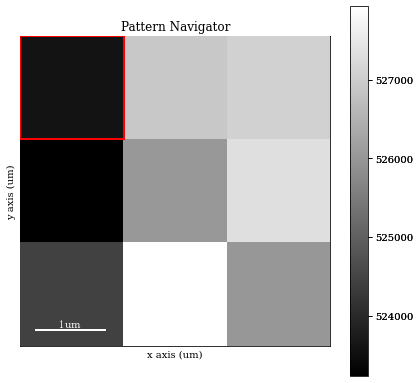

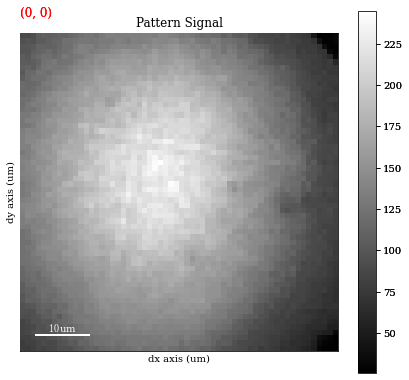

In [6]:
s.plot()

Upon loading, kikuchipy tries to read all scan information from the file and
stores everything it can read in the `original_metadata` attribute:

In [7]:
# s.original_metadata  # Long output

Also, some information may be stored in a standard location in the `metadata`
attribute where it can be used by EBSD class methods:

In [8]:
s.metadata

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EBSD
│       │       ├── azimuth_angle = 0.0
│       │       ├── binning = 1
│       │       ├── detector = NORDIF UF1100
│       │       ├── elevation_angle = 0.0
│       │       ├── exposure_time = 0.0035
│       │       ├── frame_number = -1
│       │       ├── frame_rate = 202
│       │       ├── gain = 0.0
│       │       ├── grid_type = square
│       │       ├── manufacturer = NORDIF
│       │       ├── sample_tilt = 70.0
│       │       ├── scan_time = 148
│       │       ├── static_background = array([[84, 87, 90, ..., 27, 29, 30],
       [87, 90, 93, ..., 27, 28, 30],
   ...  80, 82, ..., 28, 26, 26],
       [76, 78, 80, ..., 26, 26, 25]], dtype=uint8)
│       │       ├── version = 3.1.2
│       │       ├── xpc = -1.0
│       │       ├── ypc = -1.0
│       │       └── zpc = -1.0
│       ├── beam_energy = 20.0
│       ├── magnification = 200
│       ├── microscope = Hitachi SU-6600
│       └── working_distance = 24.7
├── General
│   ├── original_filename = ../kikuchipy/data/nordif/Pattern.dat
│   └── title = Pattern
├── Sample
│   └── Phases
│       └── 1
│           ├── atom_coordinates
│           │   └── 1
│           │       ├── atom = 
│           │       ├── coordinates = array([0., 0., 0.])
│           │       ├── debye_waller_factor = 0.0
│           │       └── site_occupation = 0.0
│           ├── formula = 
│           ├── info = 
│           ├── lattice_constants = array([0., 0., 0., 0., 0., 0.])
│           ├── laue_group = 
│           ├── material_name = Ni
│           ├── point_group = 
│           ├── setting = 0
│           ├── source = 
│           ├── space_group = 0
│           └── symmetry = 0
└── Signal
    ├── binned = False
    └── signal_type = EBSD

The number of patterns in horizontal and vertical direction, pattern size in
pixels, scan step size and detector pixel size is stored in the `axes_manager`
attribute:

In [9]:
s.axes_manager

<Axes manager, axes: (3, 3|60, 60)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      3 |      0 |       0 |     1.5 |     um 
               y |      3 |      0 |       0 |     1.5 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     60 |        |       0 |       1 |     um 
              dy |     60 |        |       0 |       1 |     um

This information can be modified directly, and information in `metadata` and
`axes_manager` can also be modified by the
[EBSD](reference.rst#kikuchipy.signals.EBSD) class methods
[set_experimental_parameters()](reference.rst#kikuchipy.signals.EBSD.set_experimental_parameters),
[set_phase_parameters()](reference.rst#kikuchipy.signals.EBSD.set_phase_parameters),
[set_scan_calibration()](reference.rst#kikuchipy.signals.EBSD.set_scan_calibration) and
[set_detector_calibration()](reference.rst#kikuchipy.signals.EBSD.set_detector_calibration).
For example, to set or change the accelerating voltage, horizontal pattern
centre coordinate and static background pattern (stored as a `numpy.ndarray`):

In [10]:
s.set_experimental_parameters(
    beam_energy=15,
    xpc=0.5073,
    static_background=plt.imread(
        datadir + "nordif/Background acquisition pattern.bmp"
    )
)

In addition to the HyperSpy provided `metadata`, `original_metadata` and
`axes_manager` properties, kikuchipy tries to read a [CrystalMap](https://orix.readthedocs.io/en/stable/reference.html#crystalmap) object with indexing results into a
`xmap` property and an
[EBSDDetector](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector)
object into a `detector` property:

In [11]:
s.xmap  # This is empty for this signal

In [12]:
s.detector

EBSDDetector (60, 60), px_size 1.0 um, binning 1, tilt 0, pc (0.5, 0.5, 0.5)

### From a NumPy array

An `EBSD` or `EBSDMasterPattern` signal can also be created directly from a
`numpy.ndarray`. To create a data set of (60 x 60) pixel patterns in a
(10 x 20) grid, i.e. 10 and 20 patterns in the horizontal and vertical scan
directions respectively, of random intensities:

In [13]:
s_np = kp.signals.EBSD(np.random.random((20, 10, 60, 60)))
s_np

<EBSD, title: , dimensions: (10, 20|60, 60)>

### From a Dask array

When processing large data sets, it is useful to load data lazily with the
Dask library. This can be done upon reading patterns [from a file](#From-a-file)
by setting `lazy=True` when using the `load()` function, or directly from a
`dask.array.Array`:

In [14]:
s_da = kp.signals.LazyEBSD(
    da.random.random((20, 10, 60, 60), chunks=(2, 10, 60, 60))
)
print(s_da)
s_da.data

<LazyEBSD, title: , dimensions: (10, 20|60, 60)>


dask.array<random_sample, shape=(20, 10, 60, 60), dtype=float64, chunksize=(2, 10, 60, 60), chunktype=numpy.ndarray>

### From a HyperSpy signal

HyperSpy provides the method
[set_signal_type()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.set_signal_type)
to change between [BaseSignal](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal) subclasses, of which
`EBSD`, `EBSDMasterPattern` and
[VirtualBSEImage](reference.rst#kikuchipy.signals.VirtualBSEImage) are three. To
get one of these objects from a [HyperSpy Signal2D](http://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.signal2d.html?highlight=signal2d#hyperspy._signals.signal2d.Signal2D)
object:

In [15]:
s_hs = hs.signals.Signal2D(np.random.random((20, 10, 60, 60)))
s_hs

<Signal2D, title: , dimensions: (10, 20|60, 60)>

In [16]:
s_hs.set_signal_type("EBSD")
s_hs

<EBSD, title: , dimensions: (10, 20|60, 60)>

In [17]:
s_hs.set_signal_type("VirtualBSEImage")
s_hs

<VirtualBSEImage, title: , dimensions: (10, 20|60, 60)>

In [18]:
s_hs.set_signal_type("EBSDMasterPattern")
s_hs

<EBSDMasterPattern, title: , dimensions: (10, 20|60, 60)>

---
## Save patterns

To save experimental EBSD patterns to file use the
[save()](reference.rst#kikuchipy.signals.EBSD.save) method. For example, to save
an `EBSD` signal in an HDF5 file, with file name `patterns.h5`, in our default
[h5ebsd format](#h5ebsd):

In [20]:
tempdir = datadir + "temp/"; os.mkdir(tempdir)
s.save(tempdir + "patterns")

FileExistsError: [Errno 17] File exists: '../kikuchipy/data/temp/'

<div class="alert alert-warning">

Warning

If we want to overwrite an existing file:

```python
s.save("patterns.h5", overwrite=True)
```

</div>

If we want to save patterns in NORDIF's binary .dat format instead:

In [21]:
s.save(tempdir + "patterns.dat")

To save an `EBSDMasterPattern` to an HDF5 file, we use the [save method inherited from HyperSpy](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.save)
to write to [their HDF5 specification](http://hyperspy.org/hyperspy-doc/current/user_guide/io.html#hspy-hyperspy-s-hdf5-specification):

In [ ]:
s_hs.save(tempdir + "master_pattern.hspy")
s_hs

These master patterns can then be read into an `EBSDMasterPattern` signal again
via HyperSpy's
[load()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.io.html#hyperspy.io.load):

In [ ]:
s_mp2 = hs.load(
    tempdir + "master_pattern.hspy", signal_type="EBSDMasterPattern"
)
s_mp2

<div class="alert alert-info">

Note

To save results from statistical decomposition (machine learning) of patterns to
file see the section
[Saving and loading results](http://hyperspy.org/hyperspy-doc/current/user_guide/mva.html#saving-and-loading-results)
in HyperSpy's user guide. Note that the file extension `.hspy` must be used upon
saving, `s.save('patterns.hspy')`, as the default extension in kikuchipy, `.h5`,
yields a kikuchipy h5ebsd file where the decomposition results aren't saved. The
saved patterns can then be reloaded using HyperSpy's `load()` function and
passing the `signal_type="EBSD"` parameter
[as explained above](#From-a-HyperSpy-signal).

</div>

---
## Supported EBSD formats

Currently, kikuchipy has readers and writers for the following formats:

| Format                          | Read | Write |
| ------------------------------- | ---- | ----- |
| Bruker Nano h5ebsd              | Yes  | No    |
| EDAX TSL h5ebsd                 | Yes  | No    |
| kikuchipy h5ebsd                | Yes  | Yes   |
| NORDIF binary                   | Yes  | Yes   |
| EMsoft simulated EBSD HDF5      | Yes  | No    |
| EMsoft EBSD master pattern HDF5 | Yes  | No    |
| Bruker Nano h5ebsd              | Yes  | No    |

<div class="alert alert-info">

Note

If you want to process your patterns with kikuchipy, but use an unsupported EBSD
vendor software, or if you want to write your processed patterns to a vendor
format that does not support writing, please request this feature in our
[issue tracker](https://github.com/pyxem/kikuchipy/issues).

</div>

### h5ebsd

The h5ebsd format
<cite data-cite="jackson2014h5ebsd">Jackson et al. (2014)</cite> is based on the
[HDF5 open standard](http://www.hdfgroup.org/HDF5) (Hierarchical Data Format
version 5). HDF5 files can be read and edited using e.g. the HDF Group's reader
[HDFView](https://www.hdfgroup.org/downloads/hdfview) or the Python package
used by kikuchipy, [h5py](http://docs.h5py.org/en/stable). Upon loading an HDF5
file with extension .h5, .hdf5, or .h5ebsd, the correct reader is determined
from the file. Supported h5ebsd formats are listed in the
[table above](#Supported-EBSD-formats).

If an h5ebsd file contains multiple scans, as many scans as desirable can be
read from the file. For example, if the file contains two scans with names
``My awes0m4 Xcan #! with a long title`` and ``Scan 2``:

In [ ]:
kikuchipy_ebsd = "kikuchipy/patterns.h5"
s_awsm, s2 = kp.load(
    filename=datadir + kikuchipy_ebsd,
    scan_group_names=["My awes0m4 Xcan #! with a long title", "Scan 2"]
)
print(s_awsm)
print(s2)

Here, the h5ebsd
[file_reader()](reference.rst#kikuchipy.io.plugins.h5ebsd.file_reader) is
called. If only `Scan 2` is to be read, `scan_group_names="Scan 2"` can be
passed:

In [ ]:
s2 = kp.load(filename=datadir + kikuchipy_ebsd, scan_group_names="Scan 2")
s2

The `scan_group_names` parameter is unnecessary if only the first scan in the
file is to be read, since reading only the first scan in the file is the default
behaviour.

So far, only [saving patterns](#Save-patterns) to kikuchipy's own h5ebsd format
is supported. It is possible to write a new scan with a scan name `Scan x`,
where `x` is an integer, to an existing, but closed, h5ebsd file in the
kikuchipy format, e.g. one containing only `Scan 1`, by passing:

In [ ]:
new_file = "patterns_new.h5"
s2.save(tempdir + new_file, scan_number=1)
s_awsm.save(filename=tempdir + new_file, add_scan=True, scan_number=2)

s2_new, s_awsm_new = kp.load(
    filename=tempdir + new_file, scan_group_names=["Scan 1", "Scan 2"]
)
print(s2_new)
print(s_awsm_new)

Here, the h5ebsd
[file_writer()](reference.rst#kikuchipy.io.plugins.h5ebsd.file_writer) is
called.

<div class="alert alert-info">

Note
    
The `EBSD.xmap` and `EBSD.detector` properties are so far not written to this
file format.

</div>

### NORDIF binary

Patterns acquired using NORDIF's acquisition software are stored in a binary
file usually named `Pattern.dat`. Scan information is stored in a separate text
file usually named `Setting.txt`, and both files usually reside in the same
directory. If this is the case, the patterns can be loaded by passing the file
name as the only parameter. If this is not the case, the setting file can be
passed upon loading:

In [ ]:
s_nordif = kp.load(
    filename=datadir + nordif_ebsd, setting_file=datadir + "nordif/Setting.txt"
)
s_nordif

Here, the NORDIF
[file_reader()](reference.rst#kikuchipy.io.plugins.nordif.file_reader) is
called. If the scan information, i.e. scan and pattern size, in the setting file
is incorrect or the setting file is not available, patterns can be loaded by
passing:

In [ ]:
s_nordif = kp.load(
    filename=datadir + nordif_ebsd, scan_size=(1, 9), pattern_size=(60, 60)
)
s_nordif

If a static background pattern named `Background acquisition.bmp` is stored in
the same directory as the pattern file, this is stored in ``metadata`` upon
loading.

Patterns can also be [saved to a NORDIF binary file](#Save-patterns), upon
which the NORDIF
[file_writer()](reference.rst#kikuchipy.io.plugins.nordif.file_writer) is
called. Note, however, that so far no new setting file, background pattern, or
calibration patterns are created upon saving.

### EMsoft simulated EBSD HDF5

Dynamically simulated EBSD patterns returned by EMsoft's `EMEBSD.f90` program
as HDF5 files can be read as an `EBSD` signal:

In [ ]:
emsoft_ebsd = "emsoft_ebsd/simulated_ebsd.h5"  # Dummy data set
s_sim = kp.load(filename=datadir + emsoft_ebsd)
s_sim

Here, the EMsoft simulated EBSD
[file_reader()](reference.rst#kikuchipy.io.plugins.emsoft_ebsd.file_reader) is
called, which takes the optional argument `scan_size`. Passing
`scan_size=(2, 5)` will reshape the pattern data shape from `(10, 10, 10)` to
`(2, 5, 10, 10)`:

In [ ]:
s_sim2 = kp.load(filename=datadir + emsoft_ebsd, scan_size=(2, 5))
print(s_sim2)
print(s_sim2.data.shape)

Simulated EBSD patterns can be written to the
[kikuchipy h5ebsd format](#h5ebsd), the [NORDIF binary format](#NORDIF-binary),
or to HDF5 files using HyperSpy's HDF5 specification
[as explained above](#Save-patterns).

### EMsoft EBSD master pattern HDF5

Master patterns returned by EMsoft's `EMEBSDmaster.f90` program as HDF5 files
can be read as an `EBSDMasterPattern` signal:

In [ ]:
s_mp = kp.load(filename=datadir + emsoft_master_pattern)

print(s_mp)
print(s_mp.projection)
print(s_mp.hemisphere)
print(s_mp.phase)

Here, the EMsoft EBSD master pattern
[file_reader()](reference.rst#kikuchipy.io.plugins.emsoft_ebsd_master_pattern.file_reader)
is called, which takes the optional arguments `projection`, `hemisphere` and
`energy`. The spherical projection is read by default. Passing
`projection="lambert"` will read the square Lambert projection instead. The
northern hemisphere is read by default. Passing `hemisphere="south"` or
`hemisphere="both"` will read the southern hemisphere projection or both,
respectively. Master patterns for all beam energies are read by default. Passing
`energy=(10, 20)` or `energy=15` will read the master pattern(s) with beam
energies from 10 to 20 keV, or just 15 keV, respectively:

In [ ]:
s_mp = kp.load(
    datadir + emsoft_master_pattern,
    projection="lambert",
    hemisphere="both",
    energy=20
)

print(s_mp)
print(s_mp.projection)
print(s_mp.hemisphere)

Master patterns can be written to HDF5 files using HyperSpy's HDF5 specification
[as explained above](#Save-patterns).

See <cite data-cite="jackson2019dictionary">Jackson et al. (2019)</cite> for a
hands-on tutorial explaining how to simulate these patterns with EMsoft, and
<cite data-cite="callahan2013dynamical">Callahan & De Graef (2013)</cite> for
details of the underlying theory.

## From kikuchipy into other software

Patterns saved in the [h5ebsd format](#h5ebsd) can be read by the
dictionary indexing and related routines in
[EMsoft](http://vbff.materials.cmu.edu/EMsoft) using the `EMEBSD` reader. Those
routines in EMsoft also have a `NORDIF` reader.

Patterns saved in the [h5ebsd format](#h5ebsd) can of course be read
in Python like any other HDF5 data set:

In [ ]:
import h5py
with h5py.File(datadir + kikuchipy_ebsd, mode="r") as f:
    dset = f['Scan 2/EBSD/Data/patterns']
    print(dset)
    patterns = dset[()]
    print(patterns.shape)
    plt.figure()
    plt.imshow(patterns[0], cmap="gray")

## Load and save virtual BSE images

One or more virtual backscatter electron (BSE) images in a
[VirtualBSEImage](reference.rst#kikuchipy.signals.VirtualBSEImage) signal can be
read and written to file using one of HyperSpy's many readers and writers. If
they are only to be used internally in HyperSpy, they can be written to and read
back from HyperSpy's HDF5 specification
[as explained above for EBSD master patterns](#Save-patterns).

If we want to write the images to image files, HyperSpy also provides a series
of image readers/writers, as explained in their
[IO user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/io.html#images).
If we wanted to write them as a stack of TIFF images:

In [ ]:
# Get virtual image from generator
vbse_gen = kp.generators.VirtualBSEGenerator(s)
print(vbse_gen)

print(vbse_gen.grid_shape)
vbse = vbse_gen.get_images_from_grid()
print(vbse)

In [ ]:
vbse.rescale_intensity()
vbse.unfold_navigation_space()  # 1D navigation space required for TIFF
vbse

In [ ]:
vbse_fname = "vbse.tif"
vbse.save(tempdir + vbse_fname)  # Easily read into e.g. ImageJ

We can also write them to e.g. `png` or `bmp` files with `Matplotlib`:

In [ ]:
nav_size = vbse.axes_manager.navigation_size
_ = [
    plt.imsave(tempdir + f"vbse{i}.png", vbse.inav[i].data)
    for i in range(nav_size)
]

Read the TIFF stack back into a `VirtualBSEImage` signal:

In [ ]:
vbse2 = hs.load(tempdir + vbse_fname, signal_type="VirtualBSEImage")
vbse2

In [ ]:
from shutil import rmtree
rmtree(tempdir)  # Remove files written to disk in this user guide